<a href="https://colab.research.google.com/github/malikbaqi12/Applied-data-science-using-pyspark-code-files/blob/main/demand_forecasting_in_supply_chain_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demand Forecasting with using Big Data

## Content
1. [Introduction](#section-intro)
2. [Importing libraries and Kaggle setup](#section-ts)
3. [Load Dataset](#section-pro)
4. [Basic Exploratory Data Analysis](#section-ten)
5. [Feature Engineering](#section-ten)
6. [Data Encoding](#section-ten)
7. [LightGB Model](#section-ten)
8. [Time Series Analysis](#section-ten)   

## 1. Introduction

#### Dataset Overview
* A store chain's 5-year data includes information on 10 different stores and 50 different products.
* The data set covers the period between 01-01-2013 and 31-12-2017.

#### Business Problem
* It is desired to create a 3-month demand forecasting model for 10 different stores and 50 different products of a chain of stores.
* Afterwards, it is desired to reduce the data set to weekly and create a demand forecasting model for 2017.

#### Variables
* date – Date of sales data (No holiday effects or store closures)
* store - Store ID Unique number for each store.
* item - Item ID Unique number for each item.
* sales – Number of items sold, Number of items sold from a particular store on a given date

## 2. Importing Libraries and Kaggle Setup

In [1]:
# Importing Libraries

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

#Kaggle setup
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



## 3. Load Dataset

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df.head(15)

,date,store,item,sales,id
0,2013-01-01,1.0,1.0,13.0,NaN
1,2013-01-02,1.0,1.0,11.0,NaN
2,2013-01-03,1.0,1.0,14.0,NaN
3,2013-01-04,1.0,1.0,13.0,NaN
4,2013-01-05,1.0,1.0,10.0,NaN
5,2013-01-06,1.0,1.0,12.0,NaN
6,2013-01-07,1.0,1.0,10.0,NaN
7,2013-01-08,1.0,1.0,9.0,NaN
8,2013-01-09,1.0,1.0,12.0,NaN
9,2013-01-10,1.0,1.0,9.0,NaN


In [3]:
print("Size of train set",train.shape)
print("Size of test set:",test.shape)

Size of train set (719464, 4)
Size of test set: (45000, 4)


In [4]:
#Removing the extra column 'id'
df.drop(['id'],inplace=True,axis=1)
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

## 4. Basic Exploratory data Analysis

In [5]:
#DATE RANGE

print("Date range:", df["date"].min(), "to", df["date"].max())
#1st Jan 2013 to 31st March, 2018

Date range: 2013-01-01 00:00:00 to 2018-03-31 00:00:00


In [6]:
# SALES DISTRIBUTION

df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    719463.000000
mean         54.539434
std          29.305152
min           0.000000
10%          21.000000
30%          35.000000
50%          50.000000
70%          67.000000
80%          79.000000
90%          96.000000
95%         110.000000
99%         137.000000
max         231.000000
Name: sales, dtype: float64

In [7]:
# NUMBER OF STORES

df["store"].nunique()

10

In [8]:
# NUMBER OF PRODUCTS

df["item"].nunique() 

50

In [9]:
# NUMBER OF PRODUCTS IN EACH STORE
df.groupby(["store"])["item"].nunique()
#Every store sells all the 50 products

store
1.0     50
2.0     50
3.0     50
4.0     50
5.0     50
6.0     50
7.0     50
8.0     50
9.0     50
10.0    50
Name: item, dtype: int64

In [10]:
# Sales statistics in store-product breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                sum       mean median        std
store item                                      
1.0   1.0   36468.0  19.971522   19.0   6.741022
      2.0   97050.0  53.148959   52.0  15.005779
      3.0   60638.0  33.208105   33.0  10.072529
      4.0   36440.0  19.956188   20.0   6.640618
      5.0   30335.0  16.612815   16.0   5.672102
...             ...        ...    ...        ...
10.0  46.0      0.0        NaN    NaN        NaN
      47.0      0.0        NaN    NaN        NaN
      48.0      0.0        NaN    NaN        NaN
      49.0      0.0        NaN    NaN        NaN
      50.0      0.0        NaN    NaN        NaN

[500 rows x 4 columns]

## 5. Feature Engineering

In [11]:
# Generating date and time parameters from given date

df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear 
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [12]:
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1.0,1.0,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1.0,1.0,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1.0,1.0,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1.0,1.0,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1.0,1.0,10.0,1,5,5,1,5,2013,1,0,0


In [13]:
# Sales statistics in store-item-month breakdown
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                            
                     sum       mean median       std
store item month                                    
1.0   1.0  1      2125.0  13.709677   13.0  4.397413
           2      2063.0  14.631206   14.0  4.668146
           3      2728.0  17.600000   17.0  4.545013
           4      3118.0  20.786667   20.0  4.894301
           5      3448.0  22.245161   22.0  6.564705
...                  ...        ...    ...       ...
10.0  49.0 2         0.0        NaN    NaN       NaN
           3         0.0        NaN    NaN       NaN
      50.0 1         0.0        NaN    NaN       NaN
           2         0.0        NaN    NaN       NaN
           3         0.0        NaN    NaN       NaN

[5046 rows x 4 columns]

In [14]:
#DEALING WITH RAMDOM NOISE
# For small datasets like this dataset, random noise can be added to the values ​​to prevent overfitting.
# Here I will add Gaussian random noise, which is normally distributed with 1 standard deviation and 0 mean.

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [15]:
#Lag/Shifted Features (Delays)
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head(10)

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1.0,1.0,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1.0,1.0,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1.0,1.0,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1.0,1.0,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1.0,1.0,10.0,1,5,5,1,5,2013,1,0,0
5,2013-01-06,1.0,1.0,12.0,1,6,6,1,6,2013,1,0,0
6,2013-01-07,1.0,1.0,10.0,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1.0,1.0,9.0,1,8,8,2,1,2013,0,0,0
8,2013-01-09,1.0,1.0,12.0,1,9,9,2,2,2013,0,0,0
9,2013-01-10,1.0,1.0,9.0,1,10,10,2,3,2013,0,0,0


In [16]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [17]:
#Moving Average Features
def moving_average_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = moving_average_features(df, [365, 546, 730])


In [18]:
#Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

## 6. Data Encoding

In [19]:
#Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764464 entries, 0 to 719463
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         764464 non-null  datetime64[ns]
 1   store                        764463 non-null  float64       
 2   item                         764463 non-null  float64       
 3   sales                        719463 non-null  float64       
 4   month                        764464 non-null  int64         
 5   day_of_month                 764464 non-null  int64         
 6   day_of_year                  764464 non-null  int64         
 7   week_of_year                 764464 non-null  int64         
 8   day_of_week                  764464 non-null  int64         
 9   year                         764464 non-null  int64         
 10  is_wknd                      764464 non-null  int64         
 11  is_month_start            

In [20]:
#One-Hot Encoding
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [21]:
#Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

## 7. LightGBM Model

In [22]:
# Train data set until the beginning of 2017 (end of 2016)
train = df.loc[(df["date"] < "2017-01-01"), :]

# First 3 months of 2017 validation set
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# Independent variables
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [23]:
# Selecting the dependent variable for the train set
Y_train = train['sales']

# Selecting the argument for the train set
X_train = train[cols]

# choosing the dependent variable for the validation set
Y_val = val['sales']

# selecting the independent variable for the validation set
X_val = val[cols] 

# Checking the shapes
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((575654,), (575654, 94), (35460,), (35460, 94))

In [24]:
# Custom Cost Function

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [25]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [26]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# percentage of validation error
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350047 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.168608	training's SMAPE: 17.179	valid_1's l1: 0.167998	valid_1's SMAPE: 17.1546
[200]	training's l1: 0.138493	training's SMAPE: 14.1696	valid_1's l1: 0.141842	valid_1's SMAPE: 14.5346
[300]	training's l1: 0.13292	training's SMAPE: 13.6118	valid_1's l1: 0.136922	valid_1's SMAPE: 14.0404
[400]	training's l1: 0.130788	training's SMAPE: 13.3988	valid_1's l1: 0.135205	valid_1's SMAPE: 13.8681
[500]	training's l1: 0.129528	training's SMAPE: 13.2726	valid_1's l1: 0.133886	valid_1's SMAPE: 13.7355
[600]	training's l1: 0.128685	training's SMAPE: 13.1879	valid_1's l1: 0.132911	valid_1's SMAPE: 13.6374
[700]	training's l1: 0.128069	training's SMAPE: 13.126	valid_1's l1: 0.132125	valid_1's SMAPE: 13.5582
[800]	training's l1: 0.127583	training's SMAPE: 

13.154291115667144

### Final Model

In [27]:
# determination of test and train dependent/independent variables

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [28]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.436173 seconds.
You can set `force_col_wise=true` to remove the overhead.


## 8. Time Series Analysis

* In this section, first of all, the train data set will be reduced to a weekly basis.
* Then, using the weekly data set, respectively:
* LightGBM Model
* Single Exponential Smoothing
* Double Exponential Smoothing
* Triple Exponential Smoothing
* ARIMA
* Sales demand forecasting models for 2017 will be created with SARIMA.
* Actual values ​​will be compared with estimated values.


### Load Dataset and EDA

In [31]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()
data.shape

# reduce dataset to weekly
data.set_index("date",inplace=True)
df= data.resample("W").mean()
df.reset_index(inplace=True)
df.head()
df.shape

df.index.freq = "W"
df.head()

,date,store,item,sales
0,2013-01-06,5.5,25.5,30.355667
1,2013-01-13,5.5,25.5,29.686286
2,2013-01-20,5.5,25.5,29.414286
3,2013-01-27,5.5,25.5,29.513714
4,2013-02-03,5.5,25.5,31.150571


In [32]:
df.shape

(261, 4)

### Feature Engineering

In [33]:
# Month
df['month'] = df.date.dt.month
# Day of Month
df['day_of_month'] = df.date.dt.day
# Day of year
df['day_of_year'] = df.date.dt.dayofyear
# Week of year
df['week_of_year'] = df.date.dt.weekofyear
# Day of week
df['day_of_week'] = df.date.dt.dayofweek
# Year
df['year'] = df.date.dt.year
# Weekend check
df["is_wknd"] = df.date.dt.weekday // 4
# Month start check
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# Month end check
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

# Lag/Shifted Features (Delays)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [31, 61, 91, 98, 105, 112])


# Moving Average Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [31, 61, 91, 98, 105, 112])


# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [10, 20, 30, 40, 50]

df = ewm_features(df, alphas, lags)

df.tail()


,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_31,sales_lag_61,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_roll_mean_31,sales_roll_mean_61,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_ewm_alpha_099_lag_10,sales_ewm_alpha_099_lag_20,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_40,sales_ewm_alpha_099_lag_50,sales_ewm_alpha_095_lag_10,sales_ewm_alpha_095_lag_20,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_40,sales_ewm_alpha_095_lag_50,sales_ewm_alpha_09_lag_10,sales_ewm_alpha_09_lag_20,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_40,sales_ewm_alpha_09_lag_50,sales_ewm_alpha_08_lag_10,sales_ewm_alpha_08_lag_20,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_40,sales_ewm_alpha_08_lag_50,sales_ewm_alpha_07_lag_10,sales_ewm_alpha_07_lag_20,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_40,sales_ewm_alpha_07_lag_50,sales_ewm_alpha_05_lag_10,sales_ewm_alpha_05_lag_20,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_40,sales_ewm_alpha_05_lag_50
256,2017-12-03,5.5,25.5,53.510286,12,3,337,48,6,2017,1,0,0,62.228421,60.280295,48.422658,39.813251,54.423685,50.767521,65.995376,58.859689,60.460285,58.396841,57.257321,59.099008,61.944343,75.326579,66.655854,44.464902,42.682299,61.949367,75.308760,66.468077,44.460477,42.696424,61.957303,75.273841,66.233661,44.454102,42.750531,61.987351,75.156915,65.763164,44.431749,43.010549,62.055540,74.967582,65.279091,44.379961,43.525509,62.454476,74.293534,64.107567,44.083539,45.549427
257,2017-12-10,5.5,25.5,44.114286,12,10,344,49,6,2017,1,0,0,67.371788,56.247940,50.839080,38.487108,42.696507,51.707629,66.866386,61.437072,56.433955,59.773793,56.659792,54.839006,61.176895,75.422743,66.631673,50.817829,42.680306,61.208154,75.417967,66.623261,50.560924,42.681093,61.247959,75.408727,66.591652,50.239210,42.687310,61.332784,75.370354,66.457776,49.591950,42.746338,61.435062,75.286875,66.225727,48.931388,42.933853,61.811809,74.858624,65.369498,47.482770,44.114856
258,2017-12-17,5.5,25.5,44.370286,12,17,351,50,6,2017,1,0,0,67.751113,54.516083,51.247317,38.742207,39.700621,53.873788,66.573825,61.892335,61.422906,57.259506,59.857674,59.207826,57.585703,75.263325,66.745140,53.133184,41.904974,57.732365,75.269527,66.740134,53.026789,41.936340,57.919282,75.276416,66.730822,52.864835,41.976160,58.306100,75.283442,66.688584,52.443647,42.066982,58.715119,75.269262,66.590118,51.889017,42.208156,59.680619,75.060169,66.057892,50.319670,43.005999
259,2017-12-24,5.5,25.5,44.423429,12,24,358,51,6,2017,1,0,0,67.669350,55.061851,51.470565,43.775416,37.193301,53.051733,66.076532,59.659316,57.221574,58.608150,57.262916,56.735838,57.708474,67.553308,66.586743,53.126072,40.050730,57.710847,67.865133,66.592892,53.121039,40.127217,57.730671,68.255527,66.599711,53.099884,40.226416,57.828991,69.037031,66.605831,52.989529,40.438996,58.011336,69.813579,66.586635,52.754905,40.684847,58.695167,71.267799,66.321517,51.722835,41.519000
260,2017-12-31,5.5,25.5,44.417429,12,31,365,52,6,2017,1,0,1,66.655037,55.817378,57.902358,45.276689,40.421110,54.660811,62.640400,62.097231,56.214744,57.256800,58.019688,58.669977,57.943342,66.656487,68.985485,53.177198,39.972504,57.933971,66.708314,68.888873,53.174881,39.979489,57.924210,66.808238,68.768714,53.169931,39.997184,57.922370,67.125349,68.528938,53.140077,40.065171,57.965401,67.597274,68.282791,53.050871,40.185654,58.320440,68.957614,67.665616,52.450275,40.745357


### LightGBM Model

In [34]:

#df = pd.get_dummies(df, columns=['day_of_week', 'month'])

df = pd.get_dummies(df)

# Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

# train-test data selection
train = df.loc[(df["date"] < "2017-01-01"), :]
test = df.loc[(df["date"] >= "2017-01-01"), :]

# Dependent and Independent variables
cols = [col for col in train.columns if col not in ['date', "sales", "year"]]
X_train = train[cols]
Y_train = train['sales']
X_test = test[cols]
Y_test = test["sales"]


In [35]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'feature_name' : 189,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200, 
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols[:189])
#lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
#lgbval = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain, feature_name=cols)

#model = lgb.train(lgb_params, lgbtrain,
          #        valid_sets=[lgbtrain, lgbval],
         #         num_boost_round=lgb_params['num_boost_round'],
           #       early_stopping_rounds=lgb_params['early_stopping_rounds'],
            #      feval=lgbm_smape, 
             #     verbose_eval=100)

lgbval = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain)
model = lgb.train(lgb_params, lgbtrain,
                   valid_sets=[lgbtrain, lgbval],
                   num_boost_round=lgb_params['num_boost_round'])

y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# percentage of test error
smape(np.expm1(y_pred_test), np.expm1(Y_test))


[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 0.172041	valid_1's l1: 0.213187
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l1: 0.169049	valid_1's l1: 0.208704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l1: 0.16612	valid_1's l1: 0.204311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l1: 0.163298	valid_1's l1: 0.200006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l1: 0.160566	valid_1'

3.373344925444753

### Feature Importance

                       feature  split       gain
51   sales_ewm_alpha_05_lag_50    160  48.167349
46   sales_ewm_alpha_07_lag_50    183  12.087733
4                  day_of_year    670   9.736439
2                        month    173   4.632800
5                 week_of_year    315   3.529493
17          sales_roll_mean_61    154   3.206748
41   sales_ewm_alpha_08_lag_50     74   2.858602
36   sales_ewm_alpha_09_lag_50     32   2.475369
14               sales_lag_105    217   2.096715
22  sales_ewm_alpha_099_lag_10    108   1.612017
25  sales_ewm_alpha_099_lag_40    136   1.263724
23  sales_ewm_alpha_099_lag_20    144   1.180727
47   sales_ewm_alpha_05_lag_10    126   0.998215
18          sales_roll_mean_91     59   0.940485
3                 day_of_month    438   0.451319
16          sales_roll_mean_31    232   0.374652
43   sales_ewm_alpha_07_lag_20    153   0.371154
12                sales_lag_91    184   0.363785
21         sales_roll_mean_112    125   0.321036
24  sales_ewm_alpha_

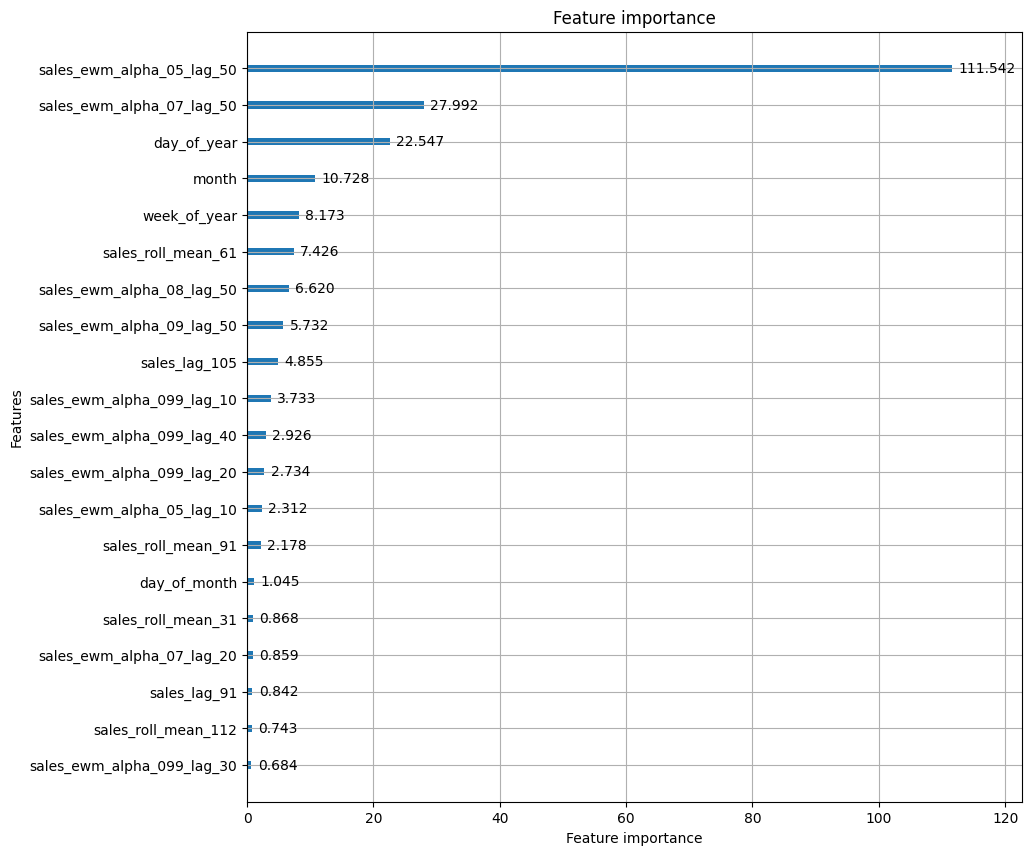

In [36]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
#plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()


In [37]:
# Final Model

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

## Here is the prediction!

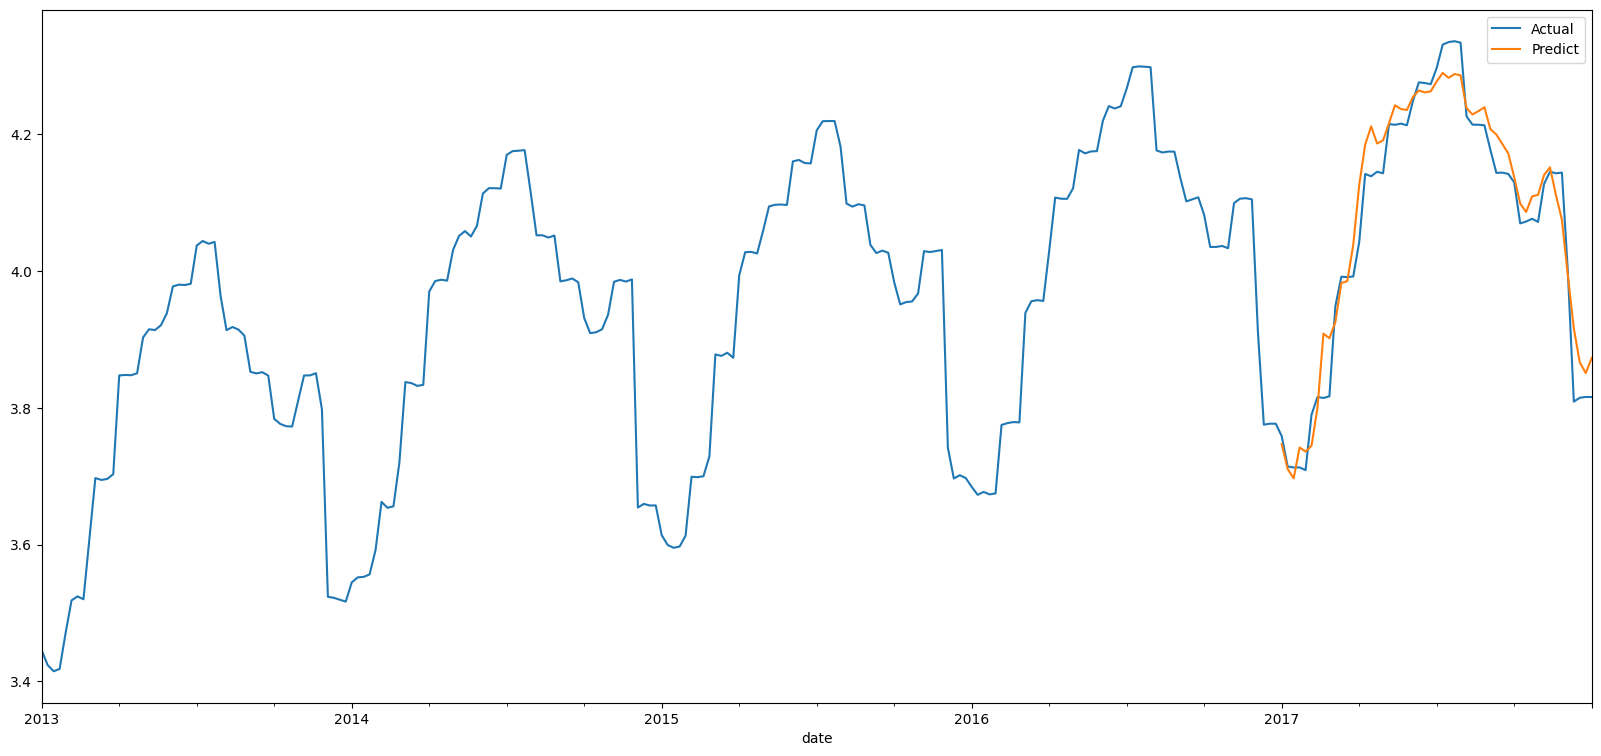

In [38]:
# 1 year actual and predicted values
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

df.set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Actual")
forecast.set_index("date").sales.plot(legend=True, label = "Predict")
plt.show()